In [1]:
# 03_Model_LogisticRegression.ipynb

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression # Importamos el modelo
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, f1_score # Añade otras métricas si necesitas
from sklearn.model_selection import train_test_split

#1. Cargar Datos y Preprocesador/Encoder



In [2]:
try:
    X_processed = pd.read_csv('./data/processed/X_processed.csv')
    y_processed = pd.read_csv('./data/processed/y_processed.csv').values.ravel()
    preprocessor = joblib.load('./models/preprocessor.joblib')
    le_target = joblib.load('./models/label_encoder_target.joblib')
    print("Datos y objetos preprocesados cargados exitosamente.")
except FileNotFoundError as e:
    print(f"Error al cargar archivos: {e}. Asegúrate de ejecutar '01_Data_Preprocessing.ipynb' primero.")
    exit()


Datos y objetos preprocesados cargados exitosamente.



#2. Definir Pipeline y Espacio de Hiperparámetros 


In [3]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000))])

param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}



#3. Búsqueda de Hiperparámetros con GridSearchCV 


In [4]:

X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42, stratify=y_processed)
print("\n Iniciando búsqueda de hiperparámetros para Regresión Logística ")
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search_lr.fit(X_processed, y_processed)

print("\nMejores hiperparámetros (Regresión Logística):", grid_search_lr.best_params_)
print("Mejor puntuación F1 Macro (Regresión Logística):", grid_search_lr.best_score_)
best_lr_model = grid_search_lr.best_estimator_ # El mejor modelo entrenado



 Iniciando búsqueda de hiperparámetros para Regresión Logística 
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Mejores hiperparámetros (Regresión Logística): {'classifier__C': 100, 'classifier__penalty': 'l1'}
Mejor puntuación F1 Macro (Regresión Logística): 0.931737279223239



#4. Evaluación del Mejor Modelo


In [6]:

y_pred = best_lr_model.predict(X_test)
print("\nReporte de Clasificación en conjunto de prueba:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_))




Reporte de Clasificación en conjunto de prueba:
              precision    recall  f1-score   support

        High       0.94      0.90      0.92       474
         Low       0.98      0.87      0.92       348
      Medium       0.93      0.97      0.95      1178

    accuracy                           0.94      2000
   macro avg       0.95      0.92      0.93      2000
weighted avg       0.94      0.94      0.94      2000




#5. Curvas de Aprendizaje 



 Generando curvas de aprendizaje para Regresión Logística 

--- Generando gráfica de convergencia para Regresión Logística ---


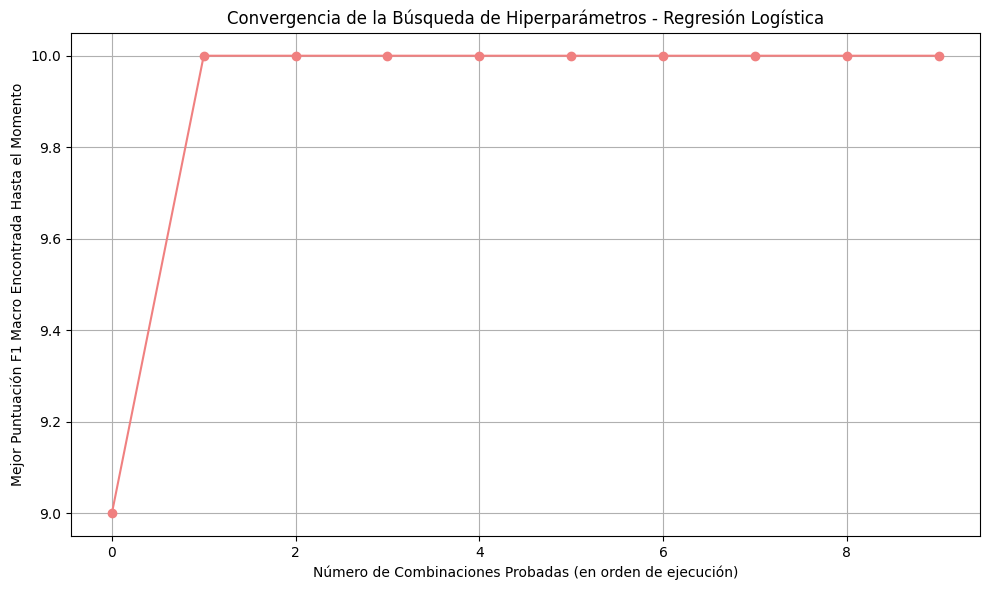

In [8]:
print("\n Generando curvas de aprendizaje para Regresión Logística ")
#Para Regresión Logística (aplicar la misma corrección)
print("\n--- Generando gráfica de convergencia para Regresión Logística ---")
results_lr = pd.DataFrame(grid_search_lr.cv_results_)

best_score_so_far_lr = []
current_best_lr = -np.inf
for score in results_lr['rank_test_score']: # <--- This will now work
    if score > current_best_lr:
        current_best_lr = score
    best_score_so_far_lr.append(current_best_lr)

plt.figure(figsize=(10, 6))
plt.plot(range(len(best_score_so_far_lr)), best_score_so_far_lr, marker='o', linestyle='-', color='lightcoral')
plt.title('Convergencia de la Búsqueda de Hiperparámetros - Regresión Logística')
plt.xlabel('Número de Combinaciones Probadas (en orden de ejecución)')
plt.ylabel('Mejor Puntuación F1 Macro Encontrada Hasta el Momento')
plt.grid(True)
plt.tight_layout()
plt.show()

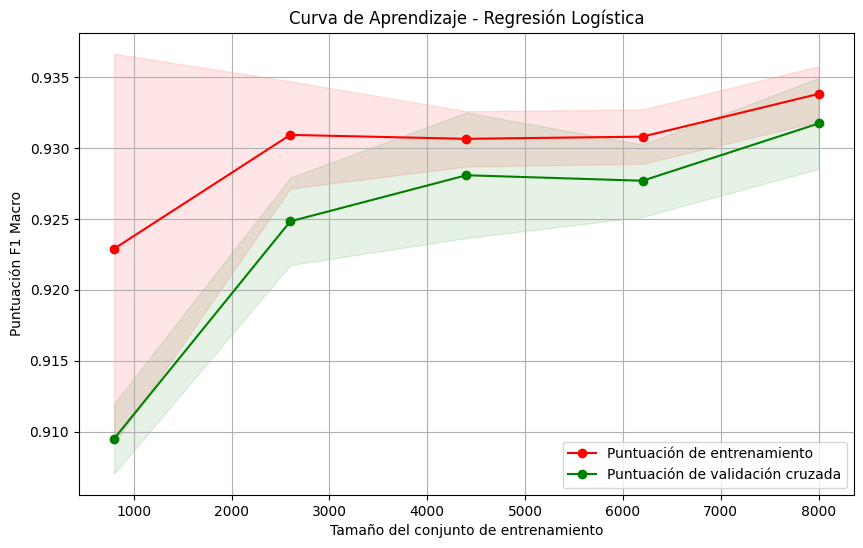

In [10]:
# Reutiliza la función plot_learning_curve definida anteriormente o impórtala desde un utils.py
# (Para simplificar, la he incluido de nuevo aquí, pero lo ideal es tenerla en un archivo de utilidades)
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Tamaño del conjunto de entrenamiento")
    axes.set_ylabel("Puntuación F1 Macro")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_macro'
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntuación de entrenamiento")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntuación de validación cruzada")
    axes.legend(loc="best")

    return plt

fig, ax = plt.subplots(figsize=(10, 6))
plot_learning_curve(best_lr_model, "Curva de Aprendizaje - Regresión Logística", X_processed, y_processed, axes=ax, cv=5, n_jobs=-1)
plt.show()



#6. Guardar el Modelo Entrenado 


In [11]:
joblib.dump(best_lr_model, './models/best_logistic_regression_model.joblib')
print("Mejor modelo Regresión Logística guardado en './models/best_logistic_regression_model.joblib'")

Mejor modelo Regresión Logística guardado en './models/best_logistic_regression_model.joblib'
